Date last updated: 10 October 2022

# **Using network analysis to improve company collaboration**

## Summary of Findings and Recommendations
This report found that:

1. The most active departments are Administration, Operations and Sales, and the least active departments are Engineering, IT and marketing.
2. The employee network is quite sparse and not very connected (but the departments are not siloed in their communications). Only if the direction of the email messages is ignored are most employees connected to each other.
3. 53% of employees have only one connection and 87% of employees have only outward-facing connections.
4. The employee with the most connections is 598; the most important gatekeepers/brokers are employees 509, 337 and 598; and the employee best connected to influential people in the company is 194 from Administration.
5. Employees with lots of connections to other employees are also likely to be bridges between otherwise disparate sections of the network.
6. Communication is frequently between employees from different departments and communities are also generally made up of members from different departments.
7. The largest sized cliques are very small and there aren't many of them.
8. The largest-sized cliques tend to include influential employees and departments.
9. The most influential departments are Administration, Sales and Operations based on departmental activity, and the employee influence and community detection analysis results.

This report **recommends** that:

1. The company should investigate why many employees have only one or two connections and explore methods of increasing the average number of connections held by employees.
2. The company should investigate why most employees in the company only ever send emails.
3. The company should analyse the data from other communication tools in use to determine if a possible reason for the low frequency of repeated communication between a pair of employees is that email is only used for formal communication.
4. The company should either focus on the Administration, Operation and Sales departments, or the Engineering, IT and Marketing departments in their initial efforts to boost collaboration. A focus on the former would perhaps be less work as it would only require investment in initiatives to boost repeated communications between pairs/groups of employees. A focus on the latter would require investment in initiatives to both boost the absolute volume of communication as well as initiatives to encourage repeated communications between pairs/groups of employees.

## Introduction

The Human Resources department of the company has sought the analytics team's assistance in mapping out the company's employee network using message data. The intent is to use the network map to better understand interdepartmental dynamics and explore how the company shares information. Ultimately, Human Resources wants this work to inform ideas about how collaboration could be improved throughout the company. Questions that they would like answers to include:

- which departments are the most and least active
- which employee is the most connected
- which departments and employees are the most influential
- what departments should be the focus of efforts to boost collaboration

## Data and Methods

The data used for this analysis consisted of 3,512 messages between 664 employees, along with associated metadata - message length, timestamp, employee department, age and location. The dataset had been anonymised and individual employees were identified using an employee id. The dataset included six months of messages; from 5:41am 2 June 2021 to 7:37am 29 November 2021. Python was used to analyse the data, with networkx used to perform the analysis and igraph used to visualise the results.

In [40]:
%%capture
!pip install igraph

In [41]:
# import libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nxcom
import networkx.algorithms.components as nxcomp
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter, OrderedDict
from itertools import count
from matplotlib.colors import LinearSegmentedColormap
from operator import itemgetter

# network visualisation
import igraph as ig

In [42]:
messages = pd.read_csv('data/messages.csv', parse_dates= ['timestamp'])
employees = pd.read_csv('data/employees.csv')
# messages.head()
# employees.head()

In [43]:
# double-check whether there are any missing values as this can really stuff up network analysis
messages.info()
employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sender          3512 non-null   int64         
 1   receiver        3512 non-null   int64         
 2   timestamp       3512 non-null   datetime64[ns]
 3   message_length  3512 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 109.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          664 non-null    int64 
 1   department  664 non-null    object
 2   location    664 non-null    object
 3   age         664 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 20.9+ KB


In [44]:
# add an edge weight attribute indicating the number of times the sender has sent a message to the receiver
messages['pair'] = messages.sender.astype('str') + " " + messages.receiver.astype('str')
pair_counts = pd.DataFrame(messages.pair.value_counts().reset_index())
pair_counts.columns = ['pair', 'weight']

messages = messages.merge(pair_counts, how = 'left', on = 'pair')
messages.drop('pair', axis = 1, inplace = True)

# add edge attributes indicating the sender's and receiver's departments
messages = messages.merge(employees[['id', 'department']], how = 'left', left_on = 'sender', right_on = 'id')
messages = messages.merge(employees[['id', 'department']], how = 'left', left_on = 'receiver', right_on = 'id')
messages.drop(['id_x', 'id_y'], axis = 1, inplace = True)
messages.rename(columns = {'department_x': 'sender_department',
                           'department_y': 'receiver_department'}, inplace = True)

In [45]:
# create the graph and view some basic initial properties about the network
# create the empty graph object
comp_net = nx.Graph()

# populate the graph with the sender and receiver columns
comp_net = nx.from_pandas_edgelist(messages,
                                   source = 'sender',
                                   target = 'receiver',
                                   edge_attr = True,
                                   create_using = nx.DiGraph())

num_nodes = nx.number_of_nodes(comp_net)
num_edges = nx.number_of_edges(comp_net)
avg_deg = num_nodes / num_edges

print("Number of nodes (employees): ", num_nodes)
print("Number of edges (connections): ", num_edges)
print("Average degree (number of connections): ", round(avg_deg, 4))
# a directed graph is strongly connected if and only if every vertex is reachable from every other vertex
print("Strongly connected: ", nx.is_strongly_connected(comp_net))
print("Weakly connected: ", nx.is_weakly_connected(comp_net))
# print("Number of strongly connected components: ", nx.number_strongly_connected_components(comp_net))
# print("Number of weakly connected components: ", nx.number_weakly_connected_components(comp_net))
print("Is a weighted graph: ", nx.is_weighted(comp_net))
print("Is a directed graph: ", nx.is_directed(comp_net))

Number of nodes (employees):  664
Number of edges (connections):  1141
Average degree (number of connections):  0.5819
Strongly connected:  False
Weakly connected:  False
Is a weighted graph:  True
Is a directed graph:  True


In [46]:
# add employee node attributes
# set the index to the node name and then convert the dataframe to a dictionary with the index orientation
nodes_attr = employees.set_index('id').to_dict(orient = 'index')
nx.set_node_attributes(comp_net, nodes_attr)

## Detailed Findings (Activity)

### Finding 1: The most-active departments are Administration, Operations and Sales

### Finding 2: The least-active departments are Engineering, IT and Marketing

In [47]:
sender_info = messages.merge(employees, how = 'left', left_on = 'sender', right_on = 'id')
all_info = sender_info.merge(employees, how = 'left', left_on = 'receiver', right_on = 'id', suffixes = ['_s', '_r'])
all_info.drop(['id_s', 'id_r'], axis = 1, inplace = True)

sender_dept_activity = all_info.groupby('department_s').size()
receiver_dept_activity = all_info.groupby('department_r').size()

receiver_info = messages.merge(employees, how = 'left', left_on = 'receiver', right_on = 'id')
dept_activity = pd.DataFrame(np.vstack((sender_info.values, receiver_info.values)), columns = sender_info.columns)
dept_activity.drop(['sender', 'receiver'], axis = 1, inplace = True)

all_dept_activity = dept_activity.groupby('department').size()

# repeat the whole exercise but looking at only inter-deparmental messages (i.e. messages going in and out of departments)
inter_info = all_info.loc[all_info.department_s != all_info.department_r]

sender_interdept_activity = inter_info.groupby('department_s').size()
receiver_interdept_activity = inter_info.groupby('department_r').size()

sender_info = inter_info[['sender', 'timestamp', 'message_length', 'department_s', 'location_s', 'age_s']]
receiver_info = inter_info[['receiver', 'timestamp', 'message_length', 'department_r', 'location_r', 'age_r']]
interdept_activity = pd.DataFrame(np.vstack((sender_info.values, receiver_info.values)), columns = sender_info.columns)

all_interdept_activity = interdept_activity.groupby('department_s').size()

# combine into one big dataframe
all_activity = pd.concat([sender_dept_activity, receiver_dept_activity, all_dept_activity, sender_interdept_activity, receiver_interdept_activity, all_interdept_activity], axis=1)
all_activity['sent interdept (%)'] = round(all_activity[3]/all_activity[0]*100, 1)
all_activity['received interdept (%)'] = round(all_activity[4]/all_activity[1]*100, 1)
all_activity['all interdept (%)'] = round(all_activity[5]/all_activity[2]*100, 1)
all_activity.drop([3,4,5], inplace = True, axis = 1)
all_activity.rename(columns = {0: 'sent', 1: 'received', 2: 'all'}, inplace = True)

print("Table 1.1: Number of messages by department including the proportion that are interdepartmental")
all_activity

Table 1.1: Number of messages by department including the proportion that are interdepartmental


sent  received   all  sent interdept (%)  received interdept (%)  \
Admin         857       797  1654                79.9                    78.4   
Engineering    26       252   278                76.9                    97.6   
IT             49       249   298                87.8                    97.6   
Marketing      16       140   156               100.0                   100.0   
Operations   1013       845  1858                80.5                    76.6   
Sales        1551      1229  2780                65.2                    56.1   

             all interdept (%)  
Admin                     79.2  
Engineering               95.7  
IT                        96.0  
Marketing                100.0  
Operations                78.7  
Sales                     61.2

In [48]:
# repeat but weighted by the number of employees in each department (assuming that every employee in the company has sent and received at least one message)
num_employees = employees.groupby('department').size()

all_activity = pd.concat([num_employees, sender_dept_activity, receiver_dept_activity, all_dept_activity, sender_interdept_activity, receiver_interdept_activity, all_interdept_activity],
                         axis=1)
all_activity['sent'] = round(all_activity[1]/all_activity[0], 2)
all_activity['received'] = round(all_activity[2]/all_activity[0], 2)
all_activity['all'] = round(all_activity[3]/all_activity[0], 2)
all_activity['sent interdept'] = round(all_activity[4]/all_activity[0], 2)
all_activity['received interdept'] = round(all_activity[5]/all_activity[0], 2)
all_activity['all interdept'] = round(all_activity[6]/all_activity[0], 2)
all_activity.drop([0,1,2,3,4,5,6], inplace = True, axis = 1)

print("Table 1.2: Number of messages by department, weighted by department size")
all_activity

Table 1.2: Number of messages by department, weighted by department size


sent  received    all  sent interdept  received interdept  \
Admin        6.12      5.69  11.81            4.89                4.46   
Engineering  0.26      2.52   2.78            0.20                2.46   
IT           0.64      3.23   3.87            0.56                3.16   
Marketing    0.31      2.69   3.00            0.31                2.69   
Operations   7.56      6.31  13.87            6.08                4.83   
Sales        9.63      7.63  17.27            6.29                4.29   

             all interdept  
Admin                 9.36  
Engineering           2.66  
IT                    3.71  
Marketing             3.00  
Operations           10.91  
Sales                10.57

Table 1.1 clearly shows that whilst Sales, Operations and Administration are the most active in terms of the numbers of messages sent and received overall, they are also the the bottom three in terms of the number of overall and received interdepartmental messages. The departments that send the least interdepartmental messages are Sales (65%) and Engineering (77%). 

Furthermore, Table 1.2 shows the average numbers of messages received and/or sent by employees of a particular department. It indicates that employees in Administration, Operations and Sales are sending and receiving many emails per person, but Engineering, Marketing and IT are sending far fewer emails than they receive (less than one per person).

Finally, out of the total 3,512 messages sent during this period, only 240 or 6.8% were a reverse pair. That is, there were only 240 messages for which the receiver sent a message back to the same sender.

In [49]:
# messages_r = messages[['sender', 'receiver']]
# messages_r["reverse_exists"] = messages_r.apply(lambda x: not messages_r[(messages_r["sender"] == x["receiver"]) &
#                                                                          (messages_r["receiver"] == x["sender"]) &
#                                                                          (messages_r.index != x.name)].empty, axis = 1)
# messages_r.reverse_exists.value_counts()

## Detailed Findings (Connectedness)

### Finding 3: The employee network is quite sparse and not very connected

There are many different ways to measure the connectedness or centralisation of a network. Two common ones are density and transitivity. Network density is a measure of how many ties exist in a network as a proportion of the total possible. The density of this network is 0.0026, which is quite low and indicates that the network is quite sparse and less cohesive. As a result, flows of information, resources and efforts to collaborate could become blocked if key employees are absent or unavailable as there are fewer possible paths along which such activities can go. In addition, the graph is not even weakly connected. This means that collaboration is not possible between some pairs or groups of employees in the company, because no pathway currently exists.

Another related concept is that of transitivity, which measures network connectedness by considering the ratio of actual connections to all possible connections. Again the score is very low (0.0046), which means that employees do not tend to cluster together and form tightly-connected communities or cliques. In order words, the chance that two employees that share a common collaborator have themselves collaborated is less than 1%.

In [50]:
# network density - ratio of actual edges to all possible edges
print("Network density: ", round(nx.density(comp_net), 4))

Network density:  0.0026


In [51]:
print("Triadic closure: ", round(nx.transitivity(comp_net), 4))

Triadic closure:  0.0046


In [52]:
# get the colour map hexcodes
cmap = mpl.cm.get_cmap('tab20')

hexcodes = []
for i in range(cmap.N):
    rgba = cmap(i)
    hex = mpl.colors.rgb2hex(rgba)
    hexcodes.append(hex)

# add node colour information
node_cmap_dict = nx.get_node_attributes(comp_net, 'department')

for key in node_cmap_dict:
    if node_cmap_dict[key] == "Admin":
        node_cmap_dict[key] = hexcodes[3]
    elif node_cmap_dict[key] == "Engineering":
        node_cmap_dict[key] = hexcodes[6]
    elif node_cmap_dict[key] == "IT":
        node_cmap_dict[key] = hexcodes[8]
    elif node_cmap_dict[key] == "Marketing":
        node_cmap_dict[key] = hexcodes[14]
    elif node_cmap_dict[key] == "Operations":
        node_cmap_dict[key] = hexcodes[18]
    else:
        node_cmap_dict[key] = hexcodes[0]

# colour nodes based on department
nx.set_node_attributes(comp_net, node_cmap_dict, 'color')
nx.set_node_attributes(comp_net, node_cmap_dict, 'frame_color')
# weight edges based on the number of messages sent between the node pairs (sender/receiver)
weight_dict = nx.get_edge_attributes(comp_net, 'edge_weight')
nx.set_edge_attributes(comp_net, weight_dict, 'weight')

In [53]:
# add edge colour information
edge_cmap_dict = nx.get_edge_attributes(comp_net, 'sender_department')

for key in edge_cmap_dict:
    if edge_cmap_dict[key] == "Admin":
        edge_cmap_dict[key] = hexcodes[3]
    elif edge_cmap_dict[key] == "Engineering":
        edge_cmap_dict[key] = hexcodes[6]
    elif edge_cmap_dict[key] == "IT":
        edge_cmap_dict[key] = hexcodes[8]
    elif edge_cmap_dict[key] == "Marketing":
        edge_cmap_dict[key] = hexcodes[14]
    elif edge_cmap_dict[key] == "Operations":
        edge_cmap_dict[key] = hexcodes[18]
    else:
        edge_cmap_dict[key] = hexcodes[0]

# colour edges based on sender department
nx.set_edge_attributes(comp_net, edge_cmap_dict, 'sender_color')

# add edge colour information
edge_cmap_dict = nx.get_edge_attributes(comp_net, 'receiver_department')

for key in edge_cmap_dict:
    if edge_cmap_dict[key] == "Admin":
        edge_cmap_dict[key] = hexcodes[3]
    elif edge_cmap_dict[key] == "Engineering":
        edge_cmap_dict[key] = hexcodes[6]
    elif edge_cmap_dict[key] == "IT":
        edge_cmap_dict[key] = hexcodes[8]
    elif edge_cmap_dict[key] == "Marketing":
        edge_cmap_dict[key] = hexcodes[14]
    elif edge_cmap_dict[key] == "Operations":
        edge_cmap_dict[key] = hexcodes[18]
    else:
        edge_cmap_dict[key] = hexcodes[0]

# colour edges based on sender department
nx.set_edge_attributes(comp_net, edge_cmap_dict, 'receiver_color')

In [54]:
# additional node attributes
# add degree attributes
degree_dict = dict(comp_net.degree(comp_net.nodes()))
nx.set_node_attributes(comp_net, degree_dict, 'degree')
indegree_dict = dict(comp_net.in_degree(comp_net.nodes()))
nx.set_node_attributes(comp_net, indegree_dict, 'indegree')
outdegree_dict = dict(comp_net.out_degree(comp_net.nodes()))
nx.set_node_attributes(comp_net, outdegree_dict, 'outdegree')

degree_centrality_dict = nx.degree_centrality(comp_net)
nx.set_node_attributes(comp_net, degree_centrality_dict, 'deg_cent')
indegree_centrality_dict = nx.in_degree_centrality(comp_net)
nx.set_node_attributes(comp_net, indegree_centrality_dict, 'indeg_cent')
outdegree_centrality_dict = nx.out_degree_centrality(comp_net)
nx.set_node_attributes(comp_net, outdegree_centrality_dict, 'outdeg_cent')

# add betweenness attributes
betweenness_dict = nx.betweenness_centrality(comp_net)
nx.set_node_attributes(comp_net, betweenness_dict, 'btw_cent')
weighted_betweenness_dict = nx.betweenness_centrality(comp_net, weight = 'weight') # used to calculate weighted shortest paths so interpreted as distances
nx.set_node_attributes(comp_net, weighted_betweenness_dict, 'weighted_btw_cent')

# add closeness attributes
closeness_dict = nx.closeness_centrality(comp_net)
nx.set_node_attributes(comp_net, closeness_dict, 'closeness_cent')
weighted_closeness_dict = nx.closeness_centrality(comp_net, distance = 'weight') # edge distance in shortest path calculations
nx.set_node_attributes(comp_net, weighted_closeness_dict, 'weighted_closeness_cent')

# add eigenvector centrality attributes
eigenvector_dict = nx.eigenvector_centrality(comp_net)
nx.set_node_attributes(comp_net, eigenvector_dict, 'eigvec_cent')
weighted_eigenvector_dict = nx.eigenvector_centrality(comp_net, weight = 'weight') # weight is the connection strength
nx.set_node_attributes(comp_net, weighted_eigenvector_dict, 'weighted_eigvec_cent')

# add PageRank attributes
pagerank_dict = nx.pagerank(comp_net, weight = None)
nx.set_node_attributes(comp_net, pagerank_dict, 'pagerank')
weighted_pagerank_dict = nx.pagerank(comp_net)
nx.set_node_attributes(comp_net, weighted_pagerank_dict, 'weighted_pagerank')

In [55]:
## additional edge attributes
edge_betweenness_dict = nx.edge_betweenness_centrality(comp_net)
nx.set_edge_attributes(comp_net, edge_betweenness_dict, 'btw_cent')
weighted_edge_betweenness_dict = nx.edge_betweenness_centrality(comp_net, weight = 'weight') # used to calculate weighted shortest paths so interpreted as distances
nx.set_edge_attributes(comp_net, weighted_edge_betweenness_dict, 'weighted_btw_cent')

In [56]:
# # check the results
# for e in list(comp_net.edges(data=True))[1:5]:
#     print(e)
# print("-----")
# for n in list(comp_net.nodes(data=True))[1:5]:
#     print(n)

The figure below indicates these points relatively clearly. For example, the company email network appears to be characterised by one-way flows of information from one employee to one or more other employees, rather than two-way communication flows that would indicate a more collaborative environment. Furthermore, most of the communication between employees during this period appear to be once-off rather than repeated efforts; this is indicated by the colours and width of the network arrows - which depict the number of times emails have been send from one employee to another during the analysis period.

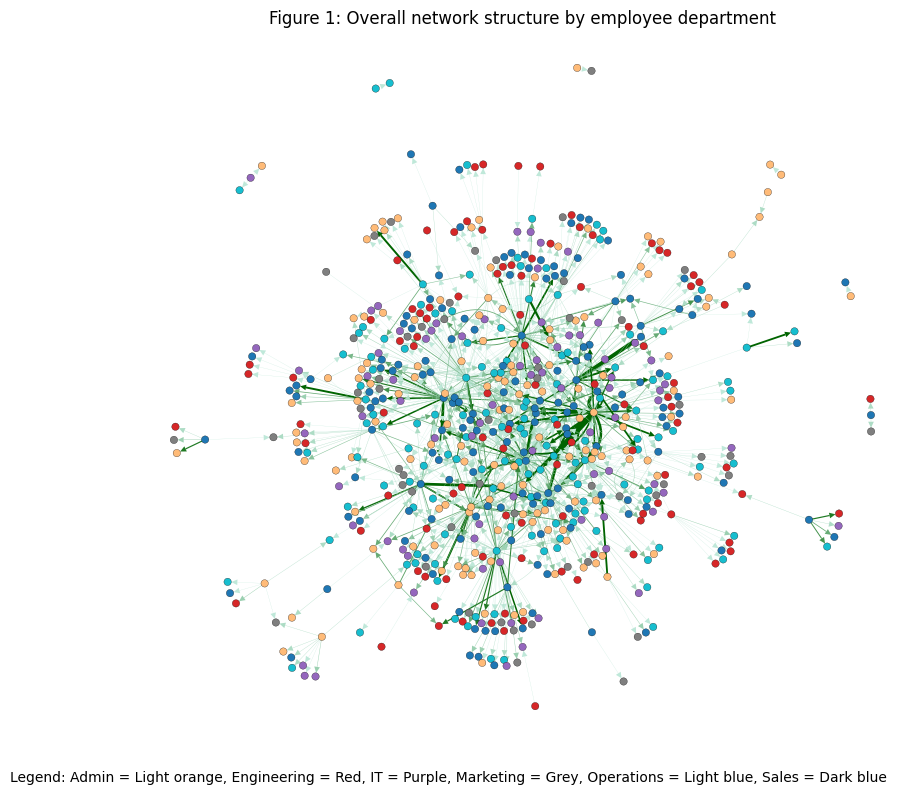

In [57]:
# convert comp_net (a networkx graph) to an igraph
comp_neti = ig.Graph.from_networkx(comp_net)

# define colour mapping for edges
edge_cmap = LinearSegmentedColormap.from_list("edge_cmap", ["lightcyan", "darkgreen"])

edge_weight = comp_neti.es["weight"]
comp_neti.es["sc_weight"] = ig.rescale(edge_weight, (0.15, 4.0), clamp = True)
comp_neti.es["color"] = [edge_cmap(e) for e in comp_neti.es["sc_weight"]]

# set up default settings for the graph
visual_style = {}
visual_style["vertex_frame_width"] = 0.2
visual_style["vertex_frame_color"] = "black"
visual_style["vertex_label_size"] = 8.0
visual_style["edge_width"] = comp_neti.es["sc_weight"]
visual_style["edge_color"] = comp_neti.es["color"]
visual_style["edge_arrow_size"] = 0.03
# visual_style["layout"] = comp_neti.layout_fruchterman_reingold()
visual_style["autocurve"] = True
visual_style["bbox"] = (2048, 1024)
visual_style["margin"] = None

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    comp_neti,
    target=ax,
    vertex_size = 0.5,
    **visual_style
)

plt.title("Figure 1: Overall network structure by employee department")
fig.text(0, 0.1, "Legend: Admin = Light orange, Engineering = Red, IT = Purple, Marketing = Grey, Operations = Light blue, Sales = Dark blue");

This last point becomes very obvious when the network graph is limited to communications that involved more than two email messages passing between the same pair of employees. (By setting the filter at two emails rather than one, possible situations in which the second email was simply a 'thank you for the information' reply were removed).

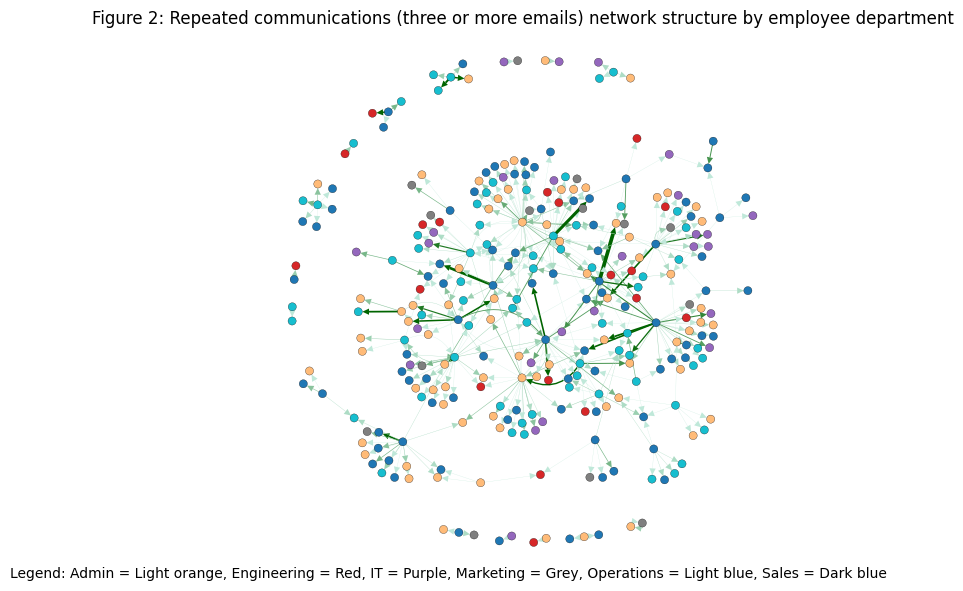

In [58]:
# retain only edges where the weight is greater than two
repeated_comms_net = nx.DiGraph((u,v,d) for u,v,d in comp_net.edges(data=True) if d['weight'] > 2)
# add back employee node attributes
nodes_attr = employees.set_index('id').to_dict(orient = 'index')
nx.set_node_attributes(repeated_comms_net, nodes_attr)

node_cmap_dict = nx.get_node_attributes(repeated_comms_net, 'department')
for key in node_cmap_dict:
    if node_cmap_dict[key] == "Admin":
        node_cmap_dict[key] = hexcodes[3]
    elif node_cmap_dict[key] == "Engineering":
        node_cmap_dict[key] = hexcodes[6]
    elif node_cmap_dict[key] == "IT":
        node_cmap_dict[key] = hexcodes[8]
    elif node_cmap_dict[key] == "Marketing":
        node_cmap_dict[key] = hexcodes[14]
    elif node_cmap_dict[key] == "Operations":
        node_cmap_dict[key] = hexcodes[18]
    else:
        node_cmap_dict[key] = hexcodes[0]
nx.set_node_attributes(repeated_comms_net, node_cmap_dict, 'color')

# convert repeated_comms_net (a networkx graph) to an igraph
repeated_comms_neti = ig.Graph.from_networkx(repeated_comms_net)

# define colour mapping for edges
edge_weight = repeated_comms_neti.es["weight"]
repeated_comms_neti.es["sc_weight"] = ig.rescale(edge_weight, (0.15, 4.0), clamp = True)
repeated_comms_neti.es["color"] = [edge_cmap(e) for e in repeated_comms_neti.es["sc_weight"]]

fig, ax = plt.subplots(figsize=(10, 7))
ig.plot(
    repeated_comms_neti,
    target=ax,
    vertex_size = 0.5,
    **visual_style
)

plt.title("Figure 2: Repeated communications (three or more emails) network structure by employee department")
fig.text(0, 0.1, "Legend: Admin = Light orange, Engineering = Red, IT = Purple, Marketing = Grey, Operations = Light blue, Sales = Dark blue");

## Detailed Findings (Centrality)

### Finding 4: 53% of employees have only one connection.

### Finding 5: 87% of employees have only outward-facing connections.

### Finding 6: The employee with the most connections is 598.

The field of network analysis provides the analyst with a variety of metrics that can be used to describe a node (employee's) position and importance in a network. However, it is important to recognise that since each metric typically has a slightly different meaning, there is no single "correct" or preferred metric. This report has included four of these metrics: degree centrality, betweenness centrality, closeness centrality, eigenvector centrality and PageRank.

The degree of a node is the number of connections that node has to another node. As this is a directed graph, the overall degree can be split up into the number of outward connections (out-degree) and the number of inward connections (in-degree). Figures 3.1 to 3.3 shows the degree distribution across the entire employee network, and indicate that most employees have very few connections. To be specific, 73% of all employees have only one or two connections, and 53% have only one. In addition, further investigation revealed that there are some employees that only send or receive emails (579 employees and 49 employees respectively).

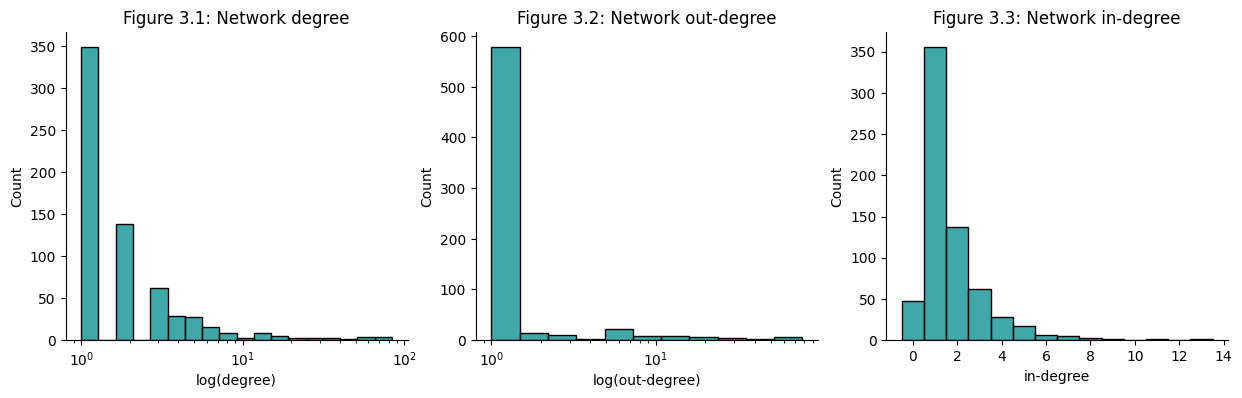

In [59]:
# plot the raw degree values
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
sns.histplot(data = degree_dict, x = degree_dict.values(), log_scale = True, color = "darkcyan", ax = ax[0])
ax[0].set_title("Figure 3.1: Network degree")
ax[0].set_xlabel("log(degree)")

sns.histplot(data = outdegree_dict, x = [x + 1 for x in list(outdegree_dict.values())], log_scale = True, color = "darkcyan", ax = ax[1])
ax[1].set_title("Figure 3.2: Network out-degree")
ax[1].set_xlabel("log(out-degree)")

sns.histplot(data = indegree_dict, x = indegree_dict.values(), discrete = True, color = "darkcyan", ax = ax[2])
ax[2].set_title("Figure 3.3: Network in-degree")
ax[2].set_xlabel("in-degree")

sns.despine()

The table below shows the top five employees by the total number of connections, the outward facing connections (number of emails sent) and the inward facing connections (number of emails received). It clearly indicates a couple of things:

1. The overall degree of an employee is dictated primarily by the number of emails send (outward degree/connections).
2. The number of emails received by an employee is far lower in magnitude than the number of emails sent.
3. Employee 598 is the most connected in the network by overall and outward connections, but employee 194 received the most emails.

In [60]:
# identify the employees / numbers of employees with the most number of connections
sorted_degree = {k: v for k, v in sorted(degree_dict.items(), key=lambda item: item[1], reverse = True)}
sorted_indegree = {k: v for k, v in sorted(indegree_dict.items(), key=lambda item: item[1], reverse = True)}
sorted_outdegree = {k: v for k, v in sorted(outdegree_dict.items(), key=lambda item: item[1], reverse = True)}

degree_dist = Counter(degree_dict.values())
sorted_dist = OrderedDict(sorted(degree_dist.items()))

most_connected = pd.DataFrame(list(sorted_degree.items())[0:5])
most_outward_connected = pd.DataFrame(list(sorted_outdegree.items())[0:5])
most_inward_connected = pd.DataFrame(list(sorted_indegree.items())[0:5])

connected_employees = pd.concat([most_connected, most_outward_connected, most_inward_connected], axis = 1)
connected_employees.columns = 'employee', 'total connections', 'employee', 'outward connections', 'employee', 'inward connections'

print("Table 2.1: Top-five most connected employees")
connected_employees

Table 2.1: Top-five most connected employees


employee  total connections  employee  outward connections  employee  \
0       598                 84       598                   77       194   
1       144                 78       144                   75        32   
2       128                 75       128                   71       249   
3       605                 71       605                   68       103   
4       586                 65       586                   64        42   

   inward connections  
0                  13  
1                  11  
2                   9  
3                   8  
4                   8

At the other end of the scale are those employees who collaborate very little with others in the company (as measured by the number of connections). The very bottom of the list are displayed in Table 2.2 below.

In [61]:
# identify the employees / numbers of employees with the least connections
sorted_degree = {k: v for k, v in sorted(degree_dict.items(), key=lambda item: item[1])}
sorted_indegree = {k: v for k, v in sorted(indegree_dict.items(), key=lambda item: item[1])}
sorted_outdegree = {k: v for k, v in sorted(outdegree_dict.items(), key=lambda item: item[1])}

least_connected = pd.DataFrame(list(sorted_degree.items())[0:47])
least_outward_connected = pd.DataFrame(list(sorted_outdegree.items())[0:47])
least_inward_connected = pd.DataFrame(list(sorted_indegree.items())[0:47])

least_connected_employees = pd.concat([least_connected, least_outward_connected, least_inward_connected], axis = 1)
least_connected_employees.columns = 'employee', 'total connections', 'employee', 'outward connections', 'employee', 'inward connections'

print("Table 2.2: Least connected employees")
least_connected_employees

Table 2.2: Least connected employees


employee  total connections  employee  outward connections  employee  \
0         58                  1        48                    0       177   
1         70                  1        63                    0       186   
2        109                  1        58                    0       237   
3         99                  1        70                    0       286   
4        121                  1       109                    0       344   
5        180                  1        99                    0       328   
6        186                  1       105                    0       162   
7        222                  1       121                    0       483   
8        195                  1        32                    0       518   
9        238                  1       180                    0       521   
10       240                  1       185                    0       643   
11        23                  1       161                    0       280   
12       248                  1       222                    0       705   
13       267                  1       195                    0       725   
14       287                  1        88                    0       776   
15       166                  1       238                    0       869   
16       256                  1       240                    0       516   
17       315                  1        23                    0       173   
18       324                  1       241                    0       977   
19       311                  1       248                    0      1005   
20       319                  1        51                    0      1054   
21       202                  1       267                    0      1140   
22       369                  1       127                    0      1162   
23       359                  1       199                    0      1176   
24       387                  1         3                    0      1274   
25       403                  1       287                    0      1252   
26       374                  1       181                    0      1421   
27       335                  1       166                    0      1308   
28       399                  1       256                    0      1443   
29       416                  1         6                    0      1461   
30       467                  1       211                    0      1487   
31       468                  1       236                    0      1496   
32       463                  1       315                    0       326   
33       429                  1        34                    0      1431   
34       493                  1       193                    0      1569   
35       345                  1       288                    0      1573   
36       521                  1       322                    0      1596   
37       305                  1       329                    0      1605   
38       496                  1       333                    0      1081   
39       519                  1       324                    0      1657   
40       424                  1       281                    0      1670   
41       559                  1       338                    0      1780   
42       568                  1       311                    0      1807   
43       449                  1       209                    0      1802   
44       589                  1       308                    0      1800   
45       481                  1       263                    0      1881   
46       409                  1       254                    0      1879   

    inward connections  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
5                    0  
6                    0  
7                    0  
8                    0  
9                    0  
10                   0  
11                   0  
12                   0  
13   

Figure 4 below highlights the general lack of connectedness in the company by resizing the network nodes (the employees) by the relative number of connections they have. It also indicates that the employees with the highest connectedness mainly belong to the Operations and Sales departments.

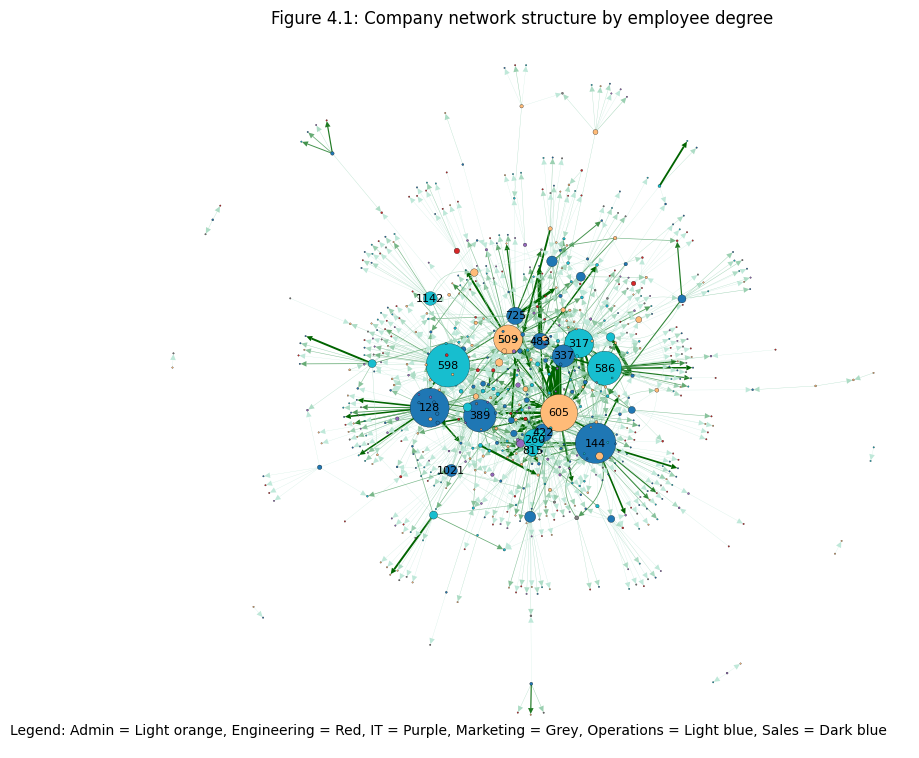

In [62]:
# define the node size according to degree
node_size = comp_neti.vs["deg_cent"]
comp_neti.vs["size"] = ig.rescale(node_size, (0.1, 3.0), clamp = True)

# define the node labels
comp_neti.vs["label"] = [n["_nx_name"] if n["degree"] > 20 else None for n in comp_neti.vs]

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    comp_neti,
    target=ax,
    **visual_style
)

plt.title("Figure 4.1: Company network structure by employee degree")
fig.text(0, 0.15, "Legend: Admin = Light orange, Engineering = Red, IT = Purple, Marketing = Grey, Operations = Light blue, Sales = Dark blue");

In [63]:
# plot the raw centrality values
# fig, ax = plt.subplots(1, 4, figsize = (15, 4))
# betweenness_dict = nx.betweenness_centrality(comp_net)
# sns.histplot(data = betweenness_dict, x = [x + 1 for x in list(outdegree_dict.values())], log_scale = True, color = "darkcyan", ax = ax[0])
# ax[0].set_title("Figure 5.1: Network betweenness")
# ax[0].set_xlabel("log(betweenness)")

# sns.histplot(data = eigenvector_dict, x = eigenvector_dict.values(), color = "darkcyan", ax = ax[1])
# ax[1].set_title("Figure 5.2: Network eigenvector centrality")
# ax[1].set_xlabel("Eigenvector")

# sns.histplot(data = pagerank_dict, x = pagerank_dict.values(),  log_scale = True, color = "darkcyan", ax = ax[2])
# ax[2].set_title("Figure 5.3: Network PageRank centrality")
# ax[2].set_xlabel("log(PageRank)")

# sns.histplot(data = closeness_dict, x = closeness_dict.values(), color = "darkcyan", ax = ax[3])
# ax[3].set_title("Figure 5.4: Network closeness centrality")
# ax[3].set_xlabel("Closeness")

# sns.despine()

### Finding 7: The most important gatekeepers/brokers are employees 509, 337 and 598.

### Finding 8: The employee best connected to influential people in the company is 194 from Administration.

Betweenness is another common metric and can be used to identify employees that act as gatekeepers or brokers in a network, where a broker is a node that bridges or connects two otherwise disconnected segments. Employees that have high betweenness scores are also employees that create "shortcuts" between network segments. Identifying these employees are important for facilitating collaboration efforts between disparate sections of the company network. There are 38 employees in the network with non-zero betweenness scores (betweenness is measured on a scale of 0 to 1), with the top three scores belonging to employee 509 from Administration, 337 from Sales and 598 from Operations. Although this is not always the case, all three employees also have high network exposure or reach.

The other two metrics most pertinent to this report are eigenvector centrality and PageRank centrality. Both of these are essentially a measure of how closely connected an employee is to the most important or influential employees in the network or company. This is why eigenvector centrality is often called the measure of "popular friends". Whilst PageRank was initially designed to measure the importance of webpages, it has since been adapted to work with network analysis by defining influential or important nodes as those that have many connections to other important nodes. The final metric, closeness centrality, is slightly different in that it defines important nodes as those that have indirect influence and are able to distribute information quickly across a network.

Table 2.1 displays the top five employees according to these centrality metrics, along with the previously discussed degree and the scores for each employee. Observe that there is very little overlap between the employees, although it appears that employee 509 from Administration is both a network broker and connected to influential members of the company and employee 32 from Sales ranks the highest on both the PageRank and closeness metrics.

Figures 5 to 7 display the network structure with node size determined by the relative magnitude of the betweenness, eigenvector and PageRank centrality scores. The most influential or important employees according to each of these metrics are labelled.

In [64]:
# select_nodes = [194]

# for n in comp_net.nodes():
#     if n in select_nodes:
#         print(comp_net.nodes[n])

In [65]:
# identify the employees / numbers of employees with the most number of connections
sorted_betweenness = {k: v for k, v in sorted(betweenness_dict.items(), key=lambda item: item[1], reverse = True)}
sorted_eigvec = {k: v for k, v in sorted(eigenvector_dict.items(), key=lambda item: item[1], reverse = True)}
sorted_pagerank = {k: v for k, v in sorted(pagerank_dict.items(), key=lambda item: item[1], reverse = True)}
sorted_closeness = {k: v for k, v in sorted(closeness_dict.items(), key=lambda item: item[1], reverse = True)}

network_brokers = pd.DataFrame(list(sorted_betweenness.items())[0:5])
connected_to_influential_persons = pd.DataFrame(list(sorted_eigvec.items())[0:5])
network_pagerank = pd.DataFrame(list(sorted_pagerank.items())[0:5])
info_spreaders = pd.DataFrame(list(sorted_closeness.items())[0:5])

influential_employees = pd.concat([most_connected, network_brokers, connected_to_influential_persons, network_pagerank, info_spreaders], axis = 1)
influential_employees.columns = 'employee', 'total connections', 'employee', 'betweenness centrality', 'employee', 'eigenvector centrality', 'employee', 'PageRank centrality', 'employee', 'closeness centrality'

print("Table 2.1: Top-five influential employees by various centrality metrics")
influential_employees

Table 2.1: Top-five influential employees by various centrality metrics


employee  total connections  employee  betweenness centrality  employee  \
0       598                 84       509                0.012186       194   
1       144                 78       337                0.011897       260   
2       128                 75       598                0.011451      1283   
3       605                 71       128                0.007266       509   
4       586                 65       260                0.006823       103   

   eigenvector centrality  employee  PageRank centrality  employee  \
0                0.186312        32             0.003091        32   
1                0.145078      1801             0.003068       194   
2                0.141281      1646             0.003035       103   
3                0.138639       779             0.002708       704   
4                0.138260       281             0.002699       840   

   closeness centrality  
0              0.025720  
1              0.025270  
2              0.024558  
3              0.022354  
4              0.021526

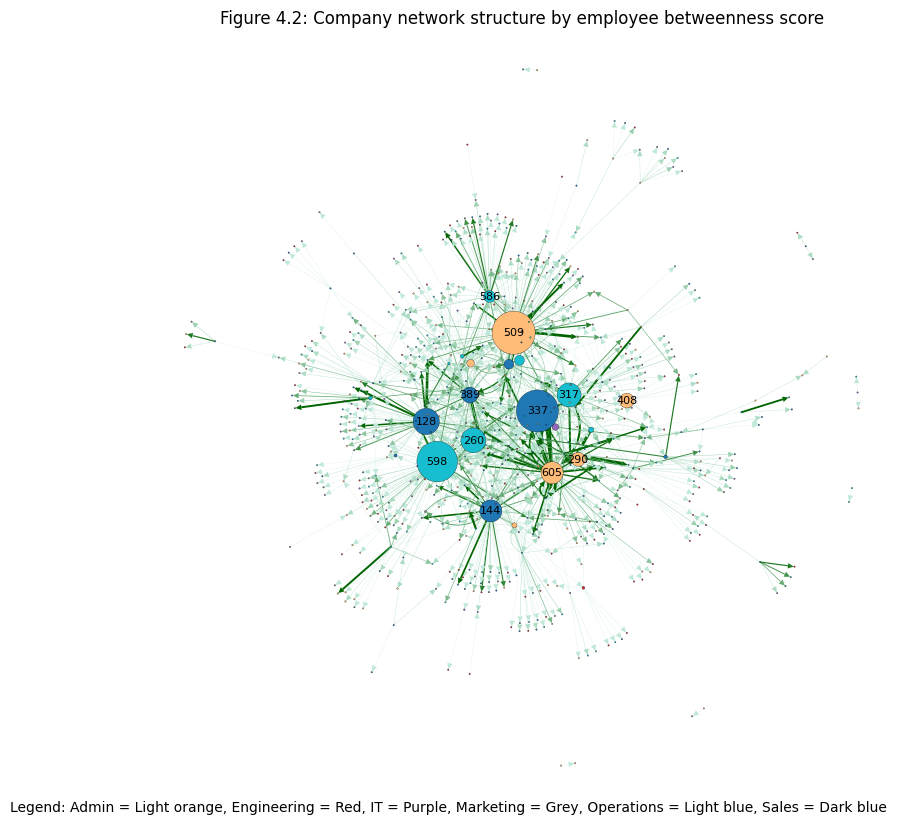

In [66]:
# change node size attribute to betweenness
node_size = comp_neti.vs["btw_cent"]
comp_neti.vs["size"] = ig.rescale(node_size, (0.1, 3.0), clamp = True)

# define the node labels
comp_neti.vs["label"] = [n["_nx_name"] if n["btw_cent"] > 0.003 else None for n in comp_neti.vs]

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    comp_neti,
    target=ax,
    **visual_style,
)

plt.title("Figure 4.2: Company network structure by employee betweenness score")
fig.text(0, 0.1, "Legend: Admin = Light orange, Engineering = Red, IT = Purple, Marketing = Grey, Operations = Light blue, Sales = Dark blue");

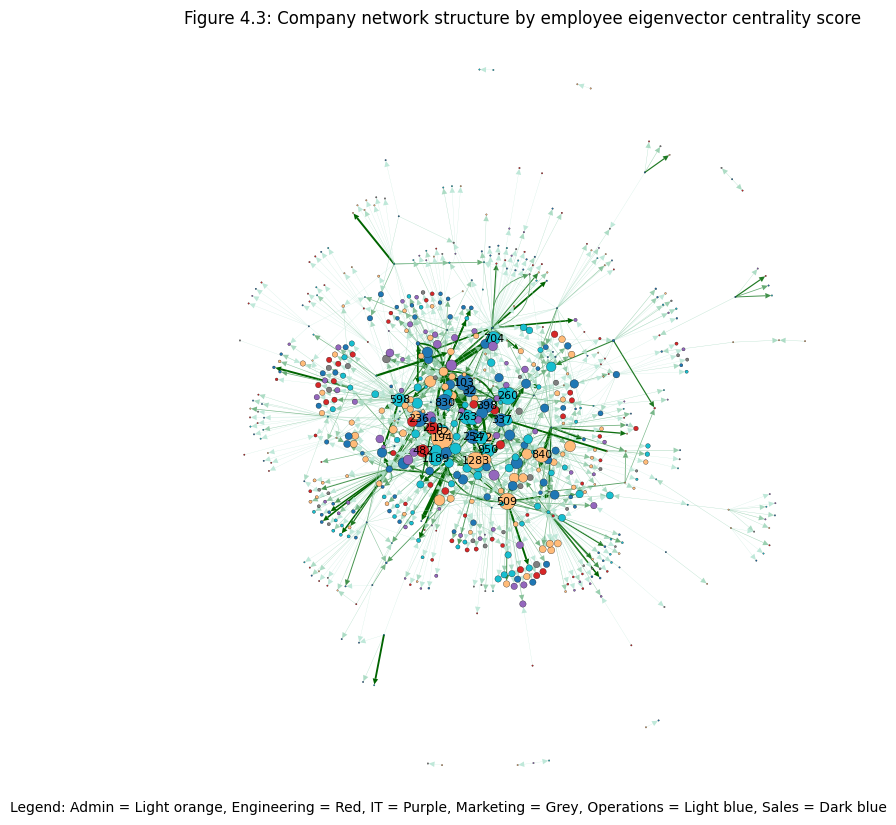

In [67]:
# change node size attribute to eigenvector centrality
node_size = comp_neti.vs["eigvec_cent"]
comp_neti.vs["size"] = ig.rescale(node_size, (0.1, 1.5), clamp = True)

# define the node labels
comp_neti.vs["label"] = [n["_nx_name"] if n["eigvec_cent"] > 0.1 else None for n in comp_neti.vs]

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    comp_neti,
    target=ax,
    **visual_style
)

plt.title("Figure 4.3: Company network structure by employee eigenvector centrality score")
fig.text(0, 0.1, "Legend: Admin = Light orange, Engineering = Red, IT = Purple, Marketing = Grey, Operations = Light blue, Sales = Dark blue");

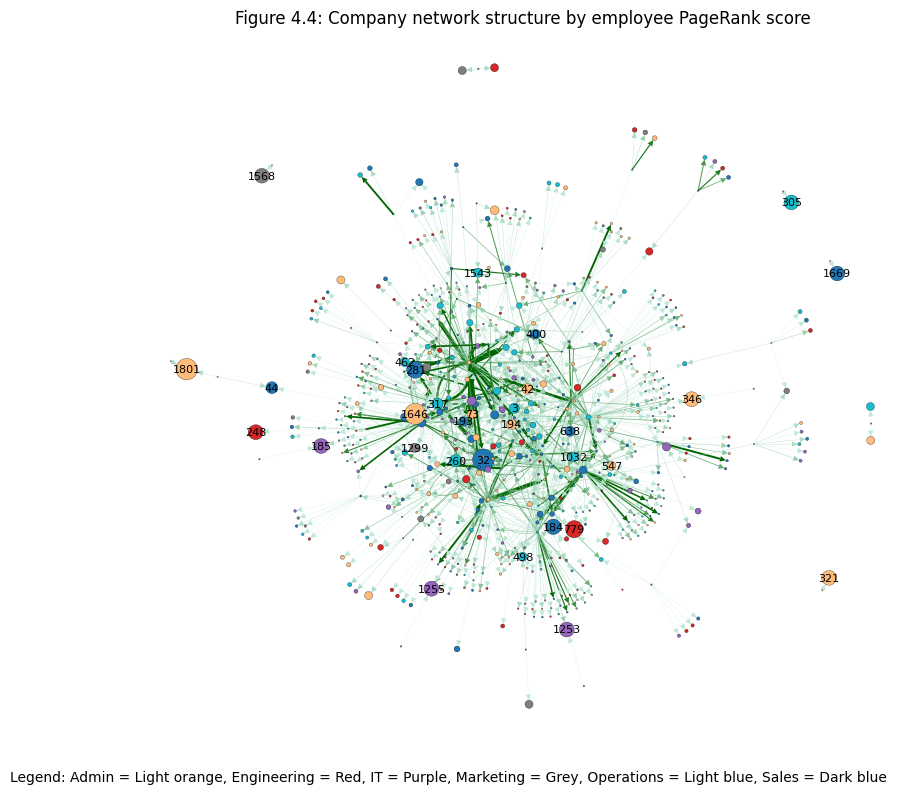

In [68]:
# change node size attribute to PageRank score
node_size = comp_neti.vs["pagerank"]
comp_neti.vs["size"] = ig.rescale(node_size, (0.1, 1.5), clamp = True)

# define the node labels
comp_neti.vs["label"] = [n["_nx_name"] if n["pagerank"] > 0.002 else None for n in comp_neti.vs]

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    comp_neti,
    target=ax,
    **visual_style
)

plt.title("Figure 4.4: Company network structure by employee PageRank score")
fig.text(0, 0.1, "Legend: Admin = Light orange, Engineering = Red, IT = Purple, Marketing = Grey, Operations = Light blue, Sales = Dark blue");

## Detailed Findings (Centrality Measure Correlation)

### Finding 9: Employees with lots of connections to other employees are also likely to be bridges between otherwise disparate sections of the network

It is always interesting to explore whether or not the values of the various centrality metrics have any sort of relationship with one another. In this network:

- overall degree is highly correlated to the outward degree and betweenness centrality, and somewhat correlated to the inward degree and eigenvector centrality
- inward degree is reasonably correlated to eigenvector and closeness centrality, with a moderate correlation to PageRank
- outward degree is only correlated with betweenness centrality and overall degree
- betweenness centrality is correlated highly to overall degree and outward degree, and somewhat correlated to eigenvector centrality
- eigenvector centrality is highly correlated to closeness centrality and inward degree, and
- PageRank is moderately correlated to inward degree only.

In summary, this means that employees that have a lot of connections, are likely to also have a lot of outward connections (sending lots of messages) and be a bridge between disparate sections of the network, and employees that have lots of connections to influential members of the company are also likely to have more inward connections (receiving lots of messages) and be a good contact if information needs to be dispersed quickly across the company.

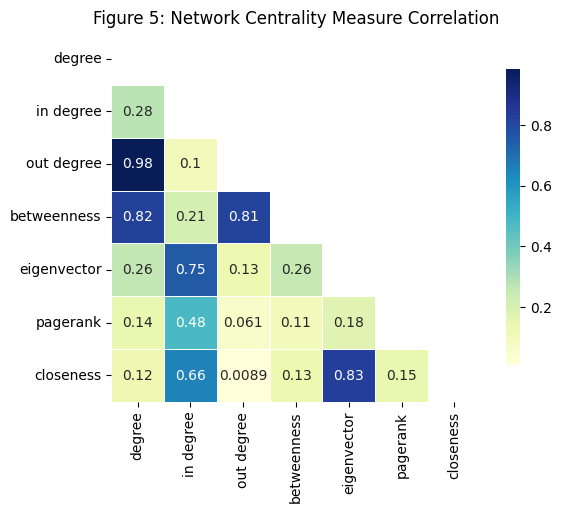

In [69]:
# create dataframes with all the values
centrality_measures = pd.concat([pd.DataFrame(comp_net.nodes.data('deg_cent')), pd.DataFrame(comp_net.nodes.data('indeg_cent')), pd.DataFrame(comp_net.nodes.data('outdeg_cent')),
                                 pd.DataFrame(comp_net.nodes.data('btw_cent')), pd.DataFrame(comp_net.nodes.data('eigvec_cent')), pd.DataFrame(comp_net.nodes.data('pagerank')),
                                 pd.DataFrame(comp_net.nodes.data('closeness_cent'))], axis=1)
centrality_measures.columns = 'employee', 'degree', 'employee', 'in degree', 'employee', 'out degree', 'employee', 'betweenness', 'employee', 'eigenvector', 'employee', 'pagerank', 'employee', 'closeness' 
centrality_measures.drop('employee', axis=1, inplace=True)

weighted_centrality_measures = pd.concat([pd.DataFrame(comp_net.nodes.data('weighted_btw_cent')), pd.DataFrame(comp_net.nodes.data('weighted_eigvec_cent')),
                                          pd.DataFrame(comp_net.nodes.data('weighted_pagerank')), pd.DataFrame(comp_net.nodes.data('weighted_closeness_cent'))], axis=1)
weighted_centrality_measures.columns = 'employee', 'betweenness', 'employee', 'eigenvector', 'employee', 'pagerank', 'employee', 'closeness' 
weighted_centrality_measures.drop('employee', axis=1, inplace=True)

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(centrality_measures.corr(), dtype=bool))

sns.heatmap(centrality_measures.corr(), 
            mask = mask, 
            cmap = "YlGnBu", 
            square = True,
            linewidths = 0.5,
            cbar_kws = {"shrink": .8},
            annot = True
           )

plt.title('Figure 5: Network Centrality Measure Correlation');

## Detailed Findings (Community Detection)

Another common area of investigation in network analysis is the structure of any sub-groups or communities that may be present. For example, is the network one big happy family in which everyone knows everyone else, or is it composed of a collection of smaller sub-groups connected by a smaller subset of intermediaries? That being said, community detection is a non-trivial exercise as both the number and size of the communities within a network can change. Hence, a variety of different algorithms have been developed to describe the community structure.

### Finding 10: Most employees are connected to each other only if the direction of the messages is ignored

Figure 9.1 below shows the seven different weakly connected employee groups present in the company network. That is, every employee is connected to every other employee in that subgroup if the direction of the email is ignored. It shows that most employees in the company are connected to each other, but a handful form completely separated subgroups. If the direction of the email is taken into account, then the number of different communities explodes to 637, which is close to the total number of employees in the company (664) and substantiates Finding 3.

In addition, this figure confirms the findings very early in the report in that there is a lot of interdepartmental activity (indicated by the fact that the edge colours of connected nodes are often different).

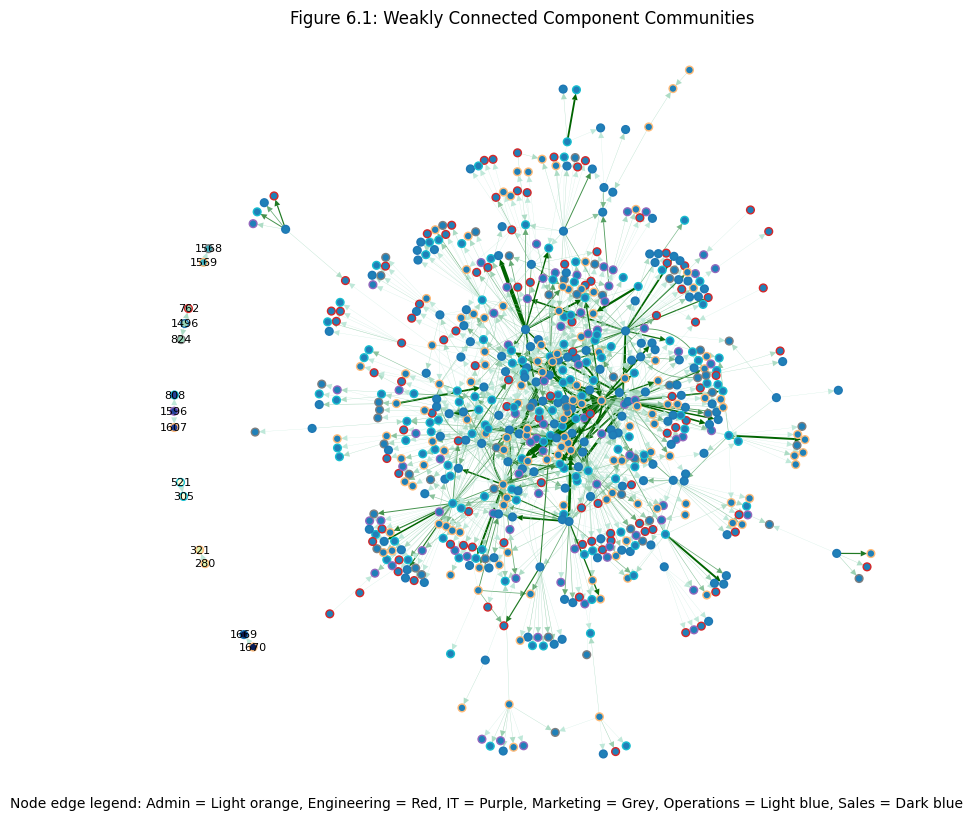

In [70]:
## weakly connected components
wcc_communities = nxcomp.weakly_connected_components(comp_net)

node_groups = []
for com in wcc_communities:
    node_groups.append(list(com))
    
# determine the number of communities
# print(len(node_groups))
# and the size of each community
# [len(group) for group in node_groups]

# get the colour map hexcodes
# cmap = mpl.cm.get_cmap('Paired')
cmap = mpl.cm.get_cmap('YlGnBu', len(node_groups))

hexcodes = []
for i in range(cmap.N):
    rgba = cmap(i)
    hex = mpl.colors.rgb2hex(rgba)
    hexcodes.append(hex)

communities_cmap = []
for node in comp_net:
    if node in node_groups[0]:
        communities_cmap.append(hexcodes[4])
    elif node in node_groups[1]:
        communities_cmap.append(hexcodes[0])
    elif node in node_groups[2]:
        communities_cmap.append(hexcodes[1])
    elif node in node_groups[3]:
        communities_cmap.append(hexcodes[2])
    elif node in node_groups[4]:
        communities_cmap.append(hexcodes[3])
    elif node in node_groups[5]:
        communities_cmap.append(hexcodes[5])
    else:
        communities_cmap.append(hexcodes[6])

# create the dictionary
wcc_dict = dict(zip([n for n in comp_net.nodes()], communities_cmap))
# colour nodes based on the dictionary
nx.set_node_attributes(comp_net, wcc_dict, 'color')

# convert comp_net (a networkx graph) to an igraph
communities_comp_neti = ig.Graph.from_networkx(comp_net)

# define colour mapping for edges
edge_cmap = LinearSegmentedColormap.from_list("edge_cmap", ["lightcyan", "darkgreen"])

edge_weight = communities_comp_neti.es["weight"]
communities_comp_neti.es["sc_weight"] = ig.rescale(edge_weight, (0.15, 4.0), clamp = True)
communities_comp_neti.es["color"] = [edge_cmap(e) for e in communities_comp_neti.es["sc_weight"]]

# define the node labels
wcc_nodes = [group for group in node_groups if len(group) < 10]
wcc_nodes = [item for sublist in wcc_nodes for item in sublist]
communities_comp_neti.vs["label"] = [n["_nx_name"] if n["_nx_name"] in wcc_nodes else None for n in communities_comp_neti.vs]

# set up default settings for the graph
visual_style2 = {}
visual_style2["vertex_size"] = 0.5
visual_style2["vertex_frame_width"] = 1.0
visual_style2["vertex_frame_color"] = communities_comp_neti.vs["frame_color"]
visual_style2["vertex_label_size"] = 8.0
visual_style2["edge_width"] = comp_neti.es["sc_weight"]
visual_style2["edge_color"] = comp_neti.es["color"]
visual_style2["edge_arrow_size"] = 0.03
visual_style2["autocurve"] = True
visual_style2["bbox"] = (2048, 1024)
visual_style2["margin"] = None

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    communities_comp_neti,
    target=ax,
    **visual_style2
);

plt.title("Figure 6.1: Weakly Connected Component Communities")
fig.text(0, 0.1, "Node edge legend: Admin = Light orange, Engineering = Red, IT = Purple, Marketing = Grey, Operations = Light blue, Sales = Dark blue");

### Finding 11: Communities are generally made up of members from different departments

One of the most popular method of exploring sub-groups in a network is that of modularity. Modularity is a measure of relative density in the network and a community (module/modularity class) has high density relative to other nodes within its module but low density with those outside. Greedy modularity maximisation is an agglomerative optimisation algorithm that starts by placing each node into its own community and progressively joining communities in order of the greatest modularity increase until no further absolute increase in modularity is possible.

Figure 6.2 shows the results of this algorithm. In total, 16 different communities in the main sub-graph were identified. Half of those sub-groups contain 40 to about 130 members and the other half contain only 4 to 21 members. As with the previous figure, the fill colour of the node indicates the sub-group and the edge colour indicates the company department.

In [71]:
# focus just on the weakly-connected subgraph
components = nx.weakly_connected_components(comp_net)
largest_component = max(components, key = len)
comp_net_subgraph = comp_net.subgraph(largest_component)

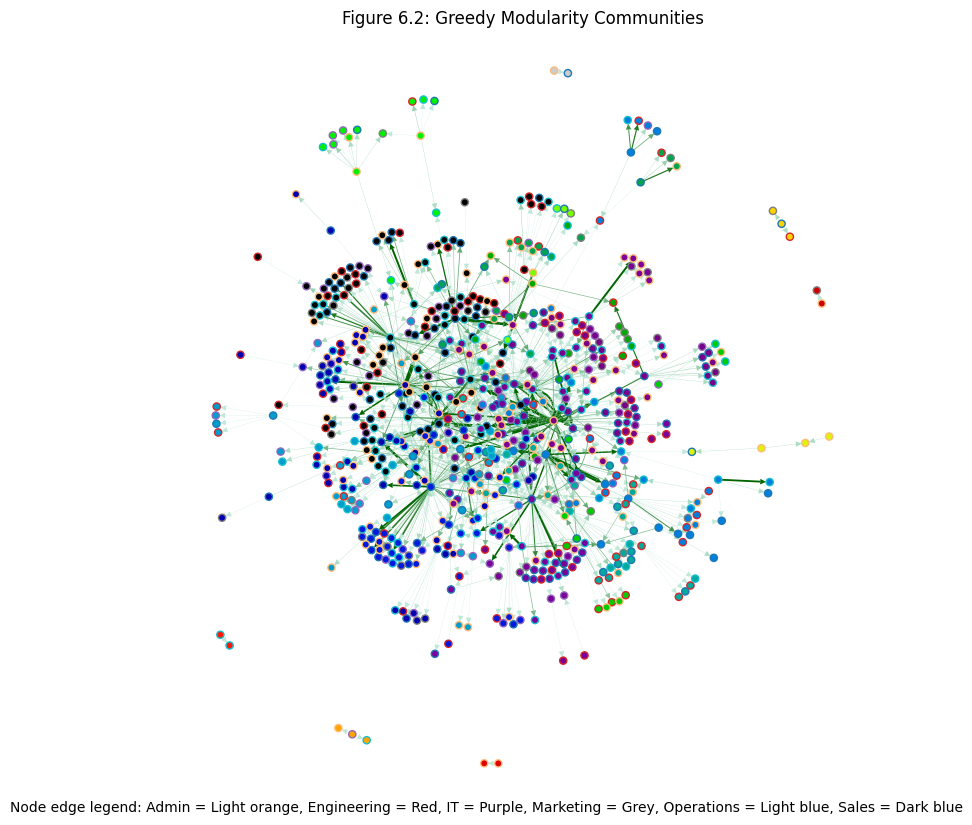

In [72]:
## greedy modularity
gm_communities = nxcom.greedy_modularity_communities(comp_net)
# weighted_gm_communities = nxcom.greedy_modularity_communities(comp_net, weight = 'weight')

node_groups = []
for com in gm_communities:
    node_groups.append(list(com))
    
# # determine the number of communities
# print(len(node_groups))
# # and the size of each community
# [len(group) for group in node_groups]

# add the communities to the graph
gm_dict = {}
for i,c, in enumerate(gm_communities):
    for name in c:
        gm_dict[name] = i
nx.set_node_attributes(comp_net, gm_dict, 'gm_communities')

# get the colour map hexcodes
cmap = mpl.cm.get_cmap('nipy_spectral', len(node_groups))

hexcodes = []
for i in range(cmap.N):
    rgba = cmap(i)
    hex = mpl.colors.rgb2hex(rgba)
    hexcodes.append(hex)
    
def get_index(node, node_groups):
    i = 0
    while(i < len(node_groups)):
        if node in node_groups[i]:
            return i
        else:
            i += 1
    return -1

communities = sorted(gm_communities, key=len, reverse=True)

communities_cmap = []
for node in comp_net:
    index = get_index(node, communities)
    if(index >= len(hexcodes)):
        print("More groups than colors; add some more colors.")
        break
    if(index == -1):
        print("Node note in a community")
        break
    communities_cmap.append(hexcodes[index])

# create the dictionary
gm_dict = dict(zip([n for n in comp_net.nodes()], communities_cmap))
# colour nodes based on the dictionary
nx.set_node_attributes(comp_net, gm_dict, 'color')

# convert comp_net (a networkx graph) to an igraph
communities_comp_neti = ig.Graph.from_networkx(comp_net)

# define colour mapping for edges
edge_cmap = LinearSegmentedColormap.from_list("edge_cmap", ["lightcyan", "darkgreen"])

edge_weight = communities_comp_neti.es["weight"]
communities_comp_neti.es["sc_weight"] = ig.rescale(edge_weight, (0.15, 4.0), clamp = True)
communities_comp_neti.es["color"] = [edge_cmap(e) for e in communities_comp_neti.es["sc_weight"]]

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    communities_comp_neti,
    target=ax,
    vertex_label=None,
    **visual_style2
);

plt.title("Figure 6.2: Greedy Modularity Communities")
fig.text(0, 0.1, "Node edge legend: Admin = Light orange, Engineering = Red, IT = Purple, Marketing = Grey, Operations = Light blue, Sales = Dark blue");

The louvain detection algorithm is another agglomerative modularity approach that is very similar to the greedy optimisation approach briefly described above but instead combines communities by moving each node to every one of its neighbouring communities and determining which move produces the highest positive modularity gain. If there is no positive gain then the node stays in its original community. As shown in Figure 6.3 below, the louvain method identified a far larger number of communities (around 57) and only about a third contain 10 or more members. The largest community has 56 members.

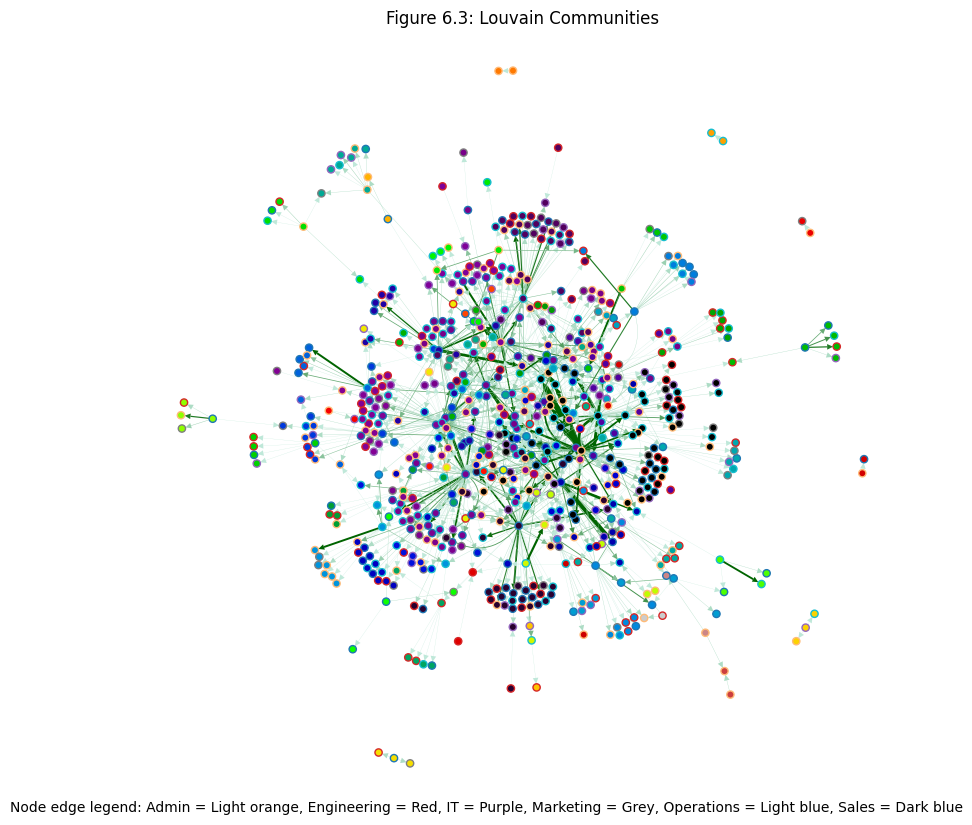

In [73]:
## louvain detection
l_communities = nxcom.louvain_communities(comp_net)

node_groups = []
for com in l_communities:
    node_groups.append(list(com))
    
# # determine the number of communities
# print(len(node_groups))
# # and the size of each community
# sizes = [len(group) for group in node_groups]
# sizes.sort()
# print(sizes)

# add the communities to the graph
l_dict = {}
for i,c, in enumerate(l_communities):
    for name in c:
        l_dict[name] = i
nx.set_node_attributes(comp_net, l_dict, 'l_communities')

# get the colour map hexcodes
cmap = mpl.cm.get_cmap('nipy_spectral', len(node_groups))

hexcodes = []
for i in range(cmap.N):
    rgba = cmap(i)
    hex = mpl.colors.rgb2hex(rgba)
    hexcodes.append(hex)
    
def get_index(node, node_groups):
    i = 0
    while(i < len(node_groups)):
        if node in node_groups[i]:
            return i
        else:
            i += 1
    return -1

communities = sorted(l_communities, key=len, reverse=True)

communities_cmap = []
for node in comp_net:
    index = get_index(node, communities)
    if(index >= len(hexcodes)):
        print("More groups than colors; add some more colors.")
        break
    if(index == -1):
        print("Node note in a community")
        break
    communities_cmap.append(hexcodes[index])

# create the dictionary
l_dict = dict(zip([n for n in comp_net.nodes()], communities_cmap))
# colour nodes based on the dictionary
nx.set_node_attributes(comp_net, l_dict, 'color')

# convert comp_net (a networkx graph) to an igraph
communities_comp_neti = ig.Graph.from_networkx(comp_net)

# define colour mapping for edges
edge_cmap = LinearSegmentedColormap.from_list("edge_cmap", ["lightcyan", "darkgreen"])

edge_weight = communities_comp_neti.es["weight"]
communities_comp_neti.es["sc_weight"] = ig.rescale(edge_weight, (0.15, 4.0), clamp = True)
communities_comp_neti.es["color"] = [edge_cmap(e) for e in communities_comp_neti.es["sc_weight"]]

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    communities_comp_neti,
    target=ax,
    vertex_label=None,
    **visual_style2
);

plt.title("Figure 6.3: Louvain Communities")
fig.text(0, 0.1, "Node edge legend: Admin = Light orange, Engineering = Red, IT = Purple, Marketing = Grey, Operations = Light blue, Sales = Dark blue");

### Finding 12: The largest sized cliques are very small and there aren't many of them.

### Finding 13: The largest-sized cliques tend to include influential employees and departments.

Cliques are a slightly different way of looking at communities in a network and whilst this is a concept generally more applicable to an undirected network, it can sometimes present some useful insights for a directed network. This is because a clique is essentially defined as a set of nodes that are all connected to each other.

There are 997 different cliques in total but the largest clique contains only 4 members and there are only six cliques of that size in this network. Interestingly, over half of the employees appearing more than once in these cliques also scored in the top five of at least one centrality metric. At the other end of the scale, there are 881 cliques containing only two members and 110 cliques containing three members. Figure 6.4 below shows the location of the maximal cliques of size 4 in the network and the members' identities.

Recall that employee 337 from Sales has the second-highest betweenness score, employee 605 from Administration is the fourth-top by overall degree (the number of connections to others), employee 598 from Operations has the highest degree and the third-highest betweenness scores, employee 194 from Administration has the highest in-degree and eigenvector scores, and the second-highest closeness score, and employee 586 from Operations has the fifth-highest overall degree score. In summary, this indicated that the maximal cliques tended to include influential employees.

In [74]:
comp_net_undir = comp_net.to_undirected()

cliques = nx.find_cliques(comp_net_undir)
# identify the number of cliques in the network
num_cliques = sorted(cliques, key = len)
len(num_cliques)
# identify the largest clique size
largest_clique_size = nx.graph_clique_number(comp_net_undir)
# identify the members of the cliques
clique_groups = [clique for clique in nx.find_cliques(comp_net_undir) if len(clique) == 4]
# then simply identidy how many there are 
# len(clique_groups)

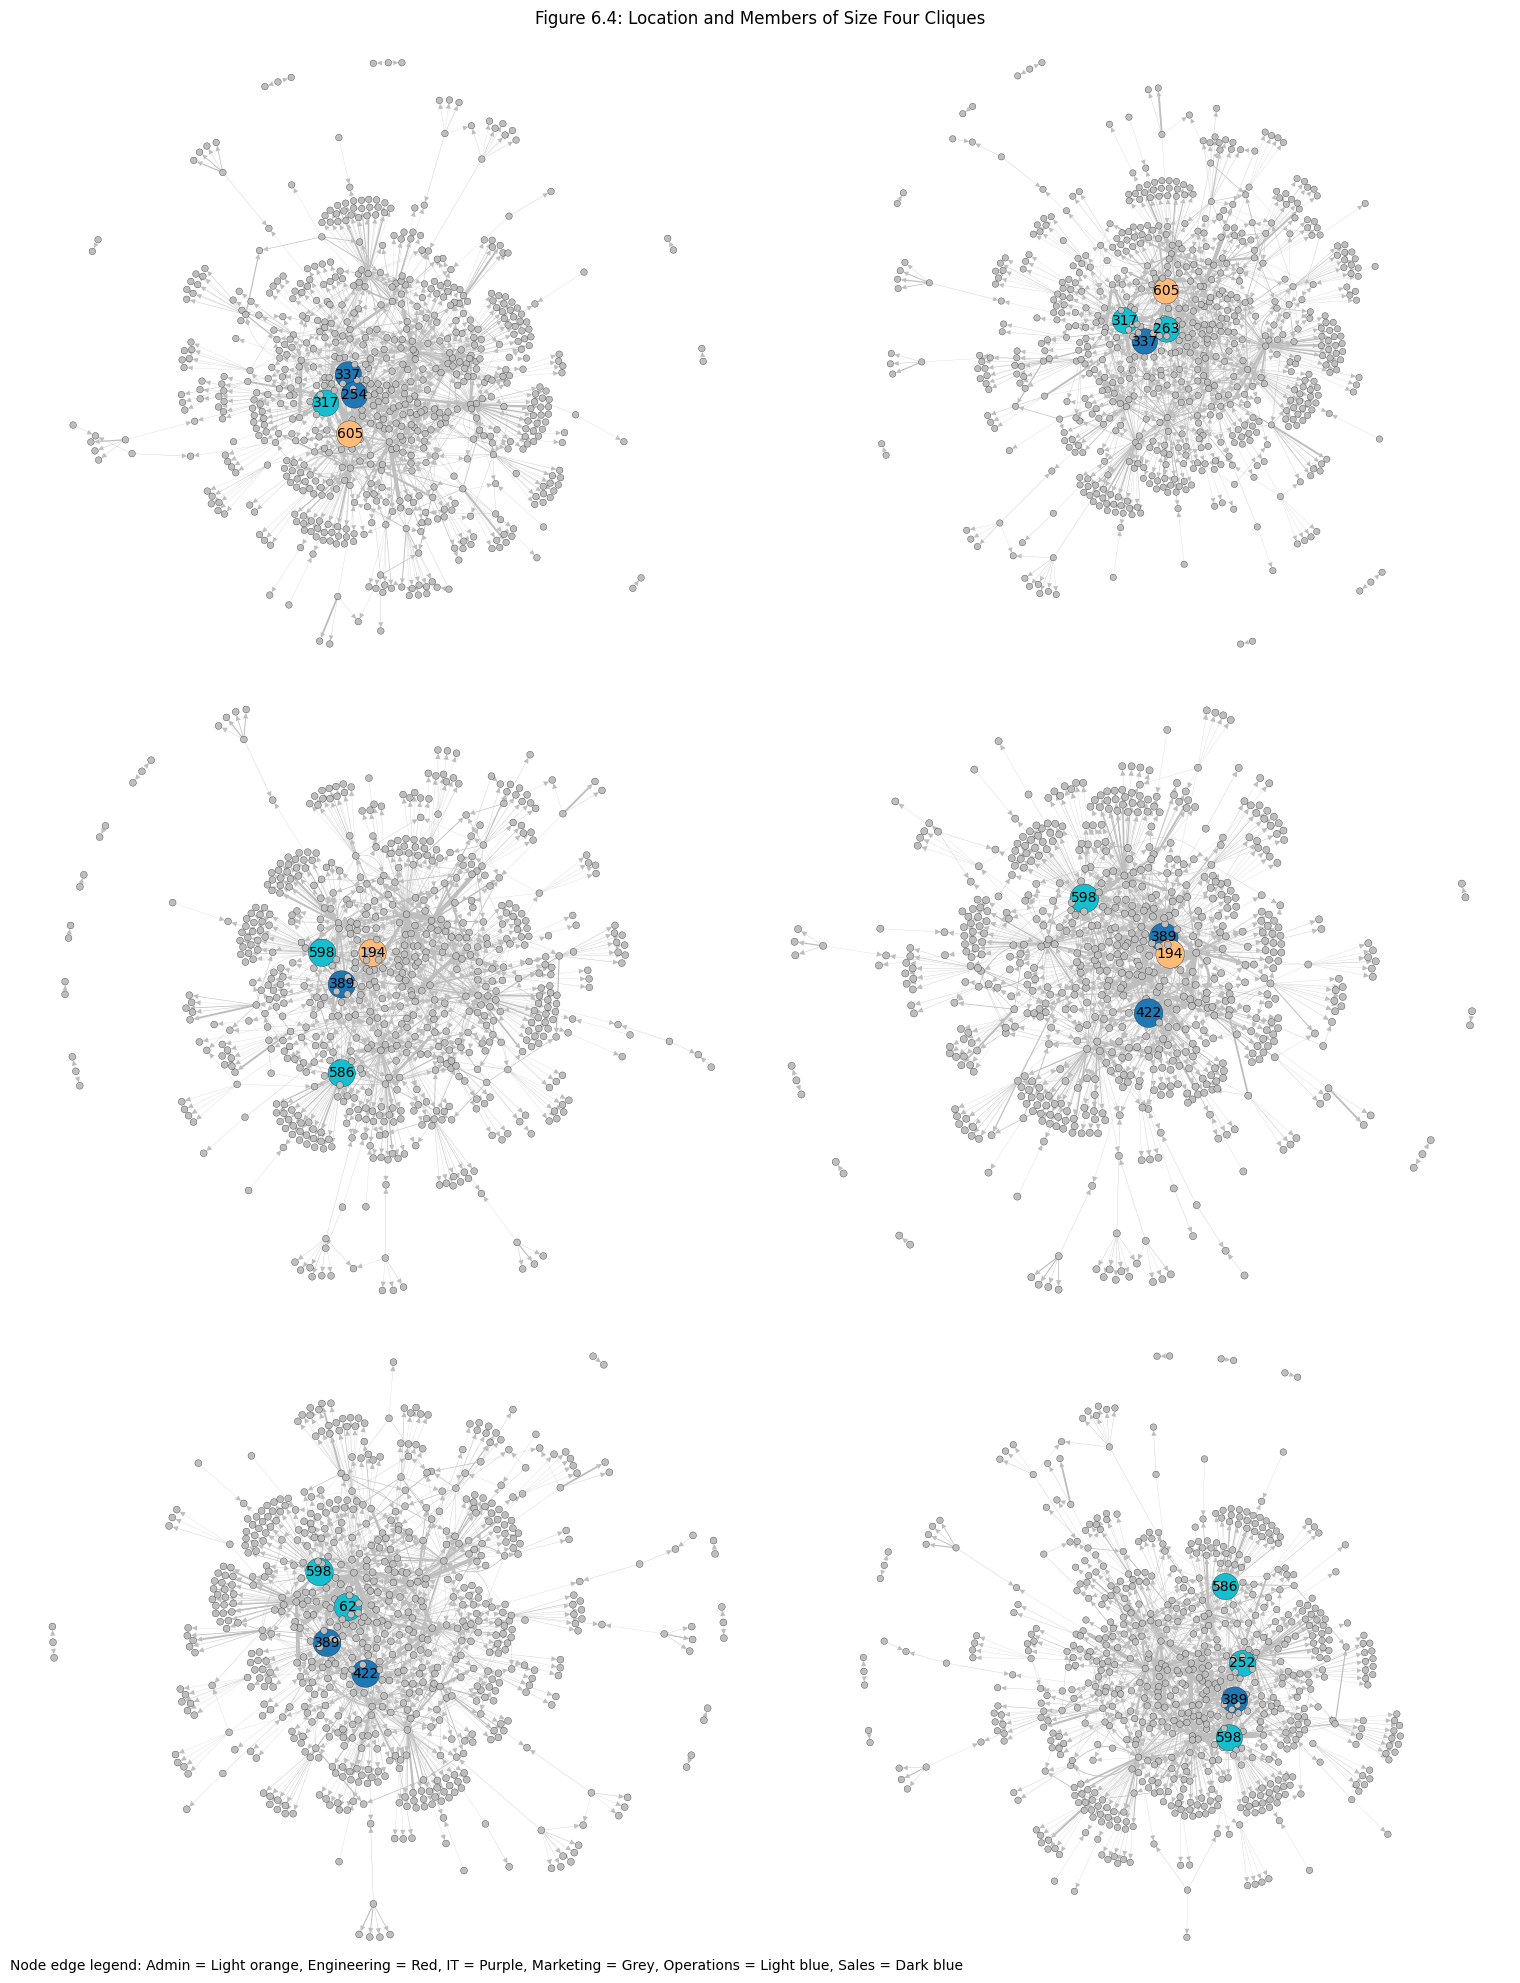

In [108]:
## cliques
# convert comp_net (a networkx graph) to an igraph
cliques_comp_neti = ig.Graph.from_networkx(comp_net)

# define edge weights
edge_weight = cliques_comp_neti.es["weight"]
cliques_comp_neti.es["sc_weight"] = ig.rescale(edge_weight, (0.15, 4.0), clamp = True)

# reset the node and frame colours
cliques_comp_neti.vs["color"] = [n["frame_color"] for n in cliques_comp_neti.vs]
cliques_comp_neti.vs["dept_color"] = [n["frame_color"] for n in cliques_comp_neti.vs]

# set up default settings for the graph
visual_style3 = {}
visual_style3["vertex_frame_width"] = 0.2
visual_style3["vertex_frame_color"] = "black"
visual_style3["vertex_label_size"] = 10.0
visual_style3["edge_width"] = comp_neti.es["sc_weight"]
visual_style3["edge_color"] = "grey"
visual_style3["edge_arrow_size"] = 0.03
visual_style3["autocurve"] = True
visual_style3["bbox"] = (2048, 1024)
visual_style3["margin"] = None

fig, axs = plt.subplots(3, 2, figsize=(15, 20))
axs = axs.ravel()

for clique, ax in zip(clique_groups, axs):
    # define when the labels are displayed
    cliques_comp_neti.vs["label"] = [n["_nx_name"] if n["_nx_name"] in clique else None for n in cliques_comp_neti.vs]
    # define when the nodes/vertices are coloured
    cliques_comp_neti.vs["color"] = [n["dept_color"] if n["_nx_name"] in clique else "grey" for n in cliques_comp_neti.vs]
    # define the sizes of the nodes/vertices
    cliques_comp_neti.vs["size"] = [2.0 if n["_nx_name"] in clique else 0.5 for n in cliques_comp_neti.vs]
    
    ig.plot(
        cliques_comp_neti,
        target=ax,
        **visual_style3
    )

plt.tight_layout(pad=0.0)
plt.suptitle("Figure 6.4: Location and Members of Size Four Cliques")
plt.subplots_adjust(top = 0.97)
fig.text(0, 0.0, "Node edge legend: Admin = Light orange, Engineering = Red, IT = Purple, Marketing = Grey, Operations = Light blue, Sales = Dark blue");

### Finding 14: The most influential departments are Administration, Sales and Operations

Whilst only the initial part of the analysis focussed on the departments and the bulk of the analysis considered influence and collaboration at the employee-level, it is reasonable to conclude that the most influential departments are Administration, Sales and Operations. Not only are they the most active in terms of sending and receiving messages, but employees from those departments tended to be high-scorers over a range of different centrality metrics. Finally, largest-sized cliques in the network were made up exclusively of employees from those three departments.

## **Appendix A: Competition Brief**

**How can the company improve collaboration?**

**📖 Background**
You work in the analytics department of a multinational company, and the head of HR wants your help mapping out the company's employee network using message data. 

They plan to use the network map to understand interdepartmental dynamics better and explore how the company shares information. The ultimate goal of this project is to think of ways to improve collaboration throughout the company.

**💾 The data**

The company has six months of information on inter-employee communication. For privacy reasons, only sender, receiver, and message length information are available [(source)](https://snap.stanford.edu/data/CollegeMsg.html). 

Messages has information on the sender, receiver, and time.
- "sender" - represents the employee id of the employee sending the message.
- "receiver" - represents the employee id of the employee receiving the message.
- "timestamp" - the date of the message.
- "message_length" - the length in words of the message.

Employees has information on each employee;
- "id" - represents the employee id of the employee.
- "department" - is the department within the company. 
- "location" - is the country where the employee lives.
- "age" - is the age of the employee.

_**Acknowledgments:** Pietro Panzarasa, Tore Opsahl, and Kathleen M. Carley. "Patterns and dynamics of users' behavior and interaction: Network analysis of an online community." Journal of the American Society for Information Science and Technology 60.5 (2009): 911-932._

**💪 Competition challenge**

Create a report that covers the following:  
  1. Which departments are the most/least active?
  2. Which employee has the most connections? 
  3. Identify the most influential departments and employees.
  4. Using the network analysis, in which departments would you recommend the HR team focus to boost collaboration?
  
**🧑‍⚖️ Judging criteria**

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul> |
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul> |
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

**✅ Checklist before publishing into the competition**a
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights. 
- Try to include an **executive summary** of your recommendations at the beginning.
- Check that all the cells run without error

**⌛️ Time is ticking. Good luck!**